In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

import tensorflow as tf  # pylint: disable=g-bad-import-order
import numpy as np

#Path to "official" tensorflow models directory
sys.path.append("./tf/models/")
from official.utils.arg_parsers import parsers
from official.utils.export import export
from official.utils.logging import hooks_helper
from official.utils.logging import logger

import resnet_ncm as resnet
import resnet_deepncm_run_loop as rrl
import cifar10_deepncm as c10

In [2]:
ALLOW_MULTIPLE_MODELS = True

# Code from cifar10_ncmnet.py

In [3]:
ds = 'cifar10'
c10.set_DS_global(ds)
DS = c10.set_dataset(ds)

set_dataset
set_dataset


In [4]:
parser = rrl.ResnetArgParser()
parser.set_defaults(resnet_size=32,
                      train_epochs=250,
                      epochs_between_evals=1,
                      batch_size=128,
                      )
flags = parser.parse_args(["--dataset","cifar10","--ncmmethod","onlinemean","--ncmparam","10","-l","0.1"])

In [5]:
flags.model_dir = DS.DEFAULT_MODEL_DIR
flags.model_dir += flags.ncmmethod

if flags.ncmmethod == "decaymean":
    flags.model_dir += "_d%02d" %(flags.ncmparam*100)
elif flags.ncmmethod == "omreset":
    flags.model_dir += "_r%04d" %(flags.ncmparam)

flags.model_dir += "_lr%5.0e" %(flags.initial_learning_scale)
flags.data_dir = DS.DATA_DIR

print(flags.model_dir)
print(flags.data_dir)

/tmp/deepncm/cifar10_resnet/onlinemean_lr1e-01
/tmp/deepncm/cifar10_data


In [6]:
input_function = c10.input_fn
model_function = c10.cifar10_model_fn
shape=[DS.HEIGHT, DS.WIDTH, DS.NUM_CHANNELS]

## Insert RRL ResNet Main code to see if mean reset works as expected

In [7]:
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'
session_config = tf.ConfigProto(
      inter_op_parallelism_threads=flags.inter_op_parallelism_threads,
      intra_op_parallelism_threads=flags.intra_op_parallelism_threads,
      allow_soft_placement=True)

if ALLOW_MULTIPLE_MODELS:
    session_config.gpu_options.allow_growth = True

run_config = tf.estimator.RunConfig().replace(
     save_checkpoints_secs = 5*60,  # Save checkpoints every X minutes.
     keep_checkpoint_max = 1000,    # Retain the 1000 most recent checkpoints.
     #tf_random_seed = 5739,         # Set random seed for "reproducible" results
     save_summary_steps = 10,       # Number of steps between summaries
     session_config=session_config)

In [8]:
classifier = tf.estimator.Estimator(
      model_fn=model_function, 
      model_dir=flags.model_dir, 
      config=run_config,
      params={
          'resnet_size': flags.resnet_size,
          'data_format': flags.data_format,
          'batch_size': flags.batch_size,
          'multi_gpu': flags.multi_gpu,
          'version': flags.version,
          'ncmmethod': flags.ncmmethod,
          'ncmparam' : flags.ncmparam,
          'initial_learning_scale' : flags.initial_learning_scale
      })

INFO:tensorflow:Using config: {'_model_dir': '/tmp/deepncm/cifar10_resnet/onlinemean_lr1e-01', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 300, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 1000, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe22580a8d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [22]:
def input_fn_eval():
      return input_function(False, flags.data_dir, flags.batch_size,1, flags.num_parallel_calls, flags.multi_gpu)
    
def input_fn_evaltrain():
      return input_function(True, flags.data_dir, flags.batch_size,1, flags.num_parallel_calls, flags.multi_gpu)

In [25]:
tf.logging.set_verbosity(tf.logging.FATAL)
MFILENAME = "cifar10_rmd_train.npz"
RUN = False

if (not os.path.exists(MFILENAME)) or RUN:
    inx = [(i*391 + 1) for i in range(0,251)]
    inx[-1] = inx[-1]-1
    #inx = [(i*391 + 1) for i in range(0,10)]
    
    methods = ["onlinemean_lr1e-01","omreset_r0390_lr1e-01","decaymean_d90_lr1e-01"]
    M = np.zeros((len(inx),3))
    for m in range(len(methods)):
        for i in range(len(inx)): 
            iinx = inx[i]
            chckptf = "/tmp/deepncm/cifar10_resnet/%s/model.ckpt-%d" %(methods[m],inx[i])
            eval_results = classifier.evaluate(input_fn=input_fn_evaltrain,checkpoint_path=chckptf)
    
            bmnorm = np.power((eval_results['batchmeans']),2).sum(axis=0)
            diffnorm = np.power((eval_results['batchmeans']-eval_results['deepmean']),2).sum(axis=0)
            rmd = (diffnorm/bmnorm).mean()
            M[i,m] = rmd
            print ("%03d %d %30s %7d | %10.5f" %(i,m,methods[m],inx[i],rmd))
    np.savez(MFILENAME,M=M,methods=methods,inx=inx)
else:
    print("Load %s" %(MFILENAME))
    npzfile = np.load(MFILENAME)
    methods = npzfile['methods']
    inx     = npzfile['inx']
    M       = npzfile['M']

000 0             onlinemean_lr1e-01       1 |    1.66764
001 0             onlinemean_lr1e-01     392 |    0.73838
002 0             onlinemean_lr1e-01     783 |    0.58765
003 0             onlinemean_lr1e-01    1174 |    0.24568
004 0             onlinemean_lr1e-01    1565 |    0.19410
005 0             onlinemean_lr1e-01    1956 |    0.12653
006 0             onlinemean_lr1e-01    2347 |    0.15135
007 0             onlinemean_lr1e-01    2738 |    0.21505
008 0             onlinemean_lr1e-01    3129 |    0.12132
009 0             onlinemean_lr1e-01    3520 |    0.14875
010 0             onlinemean_lr1e-01    3911 |    0.09484
011 0             onlinemean_lr1e-01    4302 |    0.19600
012 0             onlinemean_lr1e-01    4693 |    0.05690
013 0             onlinemean_lr1e-01    5084 |    0.08831
014 0             onlinemean_lr1e-01    5475 |    0.10176
015 0             onlinemean_lr1e-01    5866 |    0.13330
016 0             onlinemean_lr1e-01    6257 |    0.17602
017 0         

142 0             onlinemean_lr1e-01   55523 |    0.06680
143 0             onlinemean_lr1e-01   55914 |    0.07469
144 0             onlinemean_lr1e-01   56305 |    0.05099
145 0             onlinemean_lr1e-01   56696 |    0.06121
146 0             onlinemean_lr1e-01   57087 |    0.06942
147 0             onlinemean_lr1e-01   57478 |    0.04783
148 0             onlinemean_lr1e-01   57869 |    0.06247
149 0             onlinemean_lr1e-01   58260 |    0.05473
150 0             onlinemean_lr1e-01   58651 |    0.05311
151 0             onlinemean_lr1e-01   59042 |    0.05268
152 0             onlinemean_lr1e-01   59433 |    0.05285
153 0             onlinemean_lr1e-01   59824 |    0.05411
154 0             onlinemean_lr1e-01   60215 |    0.05390
155 0             onlinemean_lr1e-01   60606 |    0.05332
156 0             onlinemean_lr1e-01   60997 |    0.05333
157 0             onlinemean_lr1e-01   61388 |    0.05333
158 0             onlinemean_lr1e-01   61779 |    0.05152
159 0         

033 1          omreset_r0390_lr1e-01   12904 |    0.01180
034 1          omreset_r0390_lr1e-01   13295 |    0.00650
035 1          omreset_r0390_lr1e-01   13686 |    0.00301
036 1          omreset_r0390_lr1e-01   14077 |    0.00487
037 1          omreset_r0390_lr1e-01   14468 |    0.00319
038 1          omreset_r0390_lr1e-01   14859 |    0.00841
039 1          omreset_r0390_lr1e-01   15250 |    0.00700
040 1          omreset_r0390_lr1e-01   15641 |    0.00582
041 1          omreset_r0390_lr1e-01   16032 |    0.01571
042 1          omreset_r0390_lr1e-01   16423 |    0.00455
043 1          omreset_r0390_lr1e-01   16814 |    0.00450
044 1          omreset_r0390_lr1e-01   17205 |    0.00544
045 1          omreset_r0390_lr1e-01   17596 |    0.00315
046 1          omreset_r0390_lr1e-01   17987 |    0.00231
047 1          omreset_r0390_lr1e-01   18378 |    0.00794
048 1          omreset_r0390_lr1e-01   18769 |    0.00358
049 1          omreset_r0390_lr1e-01   19160 |    0.01227
050 1         

175 1          omreset_r0390_lr1e-01   68426 |    0.00004
176 1          omreset_r0390_lr1e-01   68817 |    0.00006
177 1          omreset_r0390_lr1e-01   69208 |    0.00004
178 1          omreset_r0390_lr1e-01   69599 |    0.00006
179 1          omreset_r0390_lr1e-01   69990 |    0.00006
180 1          omreset_r0390_lr1e-01   70381 |    0.00005
181 1          omreset_r0390_lr1e-01   70772 |    0.00003
182 1          omreset_r0390_lr1e-01   71163 |    0.00006
183 1          omreset_r0390_lr1e-01   71554 |    0.00004
184 1          omreset_r0390_lr1e-01   71945 |    0.00002
185 1          omreset_r0390_lr1e-01   72336 |    0.00003
186 1          omreset_r0390_lr1e-01   72727 |    0.00005
187 1          omreset_r0390_lr1e-01   73118 |    0.00003
188 1          omreset_r0390_lr1e-01   73509 |    0.00003
189 1          omreset_r0390_lr1e-01   73900 |    0.00008
190 1          omreset_r0390_lr1e-01   74291 |    0.00005
191 1          omreset_r0390_lr1e-01   74682 |    0.00004
192 1         

066 2          decaymean_d90_lr1e-01   25807 |    0.00947
067 2          decaymean_d90_lr1e-01   26198 |    0.00468
068 2          decaymean_d90_lr1e-01   26589 |    0.00595
069 2          decaymean_d90_lr1e-01   26980 |    0.00434
070 2          decaymean_d90_lr1e-01   27371 |    0.00540
071 2          decaymean_d90_lr1e-01   27762 |    0.00443
072 2          decaymean_d90_lr1e-01   28153 |    0.00279
073 2          decaymean_d90_lr1e-01   28544 |    0.00281
074 2          decaymean_d90_lr1e-01   28935 |    0.00238
075 2          decaymean_d90_lr1e-01   29326 |    0.00549
076 2          decaymean_d90_lr1e-01   29717 |    0.00421
077 2          decaymean_d90_lr1e-01   30108 |    0.00276
078 2          decaymean_d90_lr1e-01   30499 |    0.00343
079 2          decaymean_d90_lr1e-01   30890 |    0.00267
080 2          decaymean_d90_lr1e-01   31281 |    0.00466
081 2          decaymean_d90_lr1e-01   31672 |    0.00621
082 2          decaymean_d90_lr1e-01   32063 |    0.00679
083 2         

208 2          decaymean_d90_lr1e-01   81329 |    0.00011
209 2          decaymean_d90_lr1e-01   81720 |    0.00011
210 2          decaymean_d90_lr1e-01   82111 |    0.00010
211 2          decaymean_d90_lr1e-01   82502 |    0.00010
212 2          decaymean_d90_lr1e-01   82893 |    0.00011
213 2          decaymean_d90_lr1e-01   83284 |    0.00011
214 2          decaymean_d90_lr1e-01   83675 |    0.00015
215 2          decaymean_d90_lr1e-01   84066 |    0.00011
216 2          decaymean_d90_lr1e-01   84457 |    0.00011
217 2          decaymean_d90_lr1e-01   84848 |    0.00016
218 2          decaymean_d90_lr1e-01   85239 |    0.00014
219 2          decaymean_d90_lr1e-01   85630 |    0.00015
220 2          decaymean_d90_lr1e-01   86021 |    0.00015
221 2          decaymean_d90_lr1e-01   86412 |    0.00012
222 2          decaymean_d90_lr1e-01   86803 |    0.00009
223 2          decaymean_d90_lr1e-01   87194 |    0.00010
224 2          decaymean_d90_lr1e-01   87585 |    0.00012
225 2         

In [14]:
import matplotlib.pyplot as plt

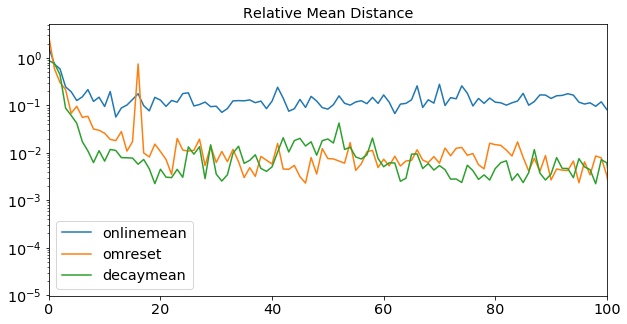

In [37]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.plot(np.arange(0,251),M)
plt.legend([m.split('_')[0] for m in methods])
plt.xlim(0,100)
plt.yscale("log")
plt.title("Relative Mean Distance")
plt.savefig("./exp_cifar10_rmd.pdf",dpi=250,bbox_inches="tight",pad_inches=0.1,transparent=False,facecolor='w')
plt.show()

In [30]:
[m.split('_')[0] for m in methods]

['onlinemean', 'omreset', 'decaymean']